In [1]:
from timeit import default_timer as timer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
# import keras models, layers and optimizers
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam

import tensorflow as tf

In [2]:
raw_data = pd.read_csv("old_data/raw_metacritic_game_user_comments.csv")
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

game_info_data = game_info_data.rename(columns={"Unnamed: 0" : "Id"})

In [3]:
all_data = pd.concat([train_data, test_data, valid_data], ignore_index=True)
#all_data = pd.concat([train_data, test_data, valid_data])

In [4]:
# transform usernames into user IDs
user_to_id_map = {}
for i, username in enumerate(np.unique(all_data["Username"])):
    user_to_id_map[username] = i

In [5]:
def format_data(data, usermap):
    # replaces usernames with numeric IDs
    user_ids = []
    for user in data["Username"]:
        user_ids.append(user_to_id_map[user])
    #print(user_ids)
    #for i in range(len(data)):
    #for i in range(len(data)):
    #    data["Username"][i] = user_to_id_map[data["Username"][i]]
        
    #fmt = data["Username"].astype(int)
    data.insert(4, "User_ID", user_ids, allow_duplicates=True)
    data = data.drop(["Unnamed: 0"], axis=1)
    return data

In [6]:
#print(all_data.loc[16220])
#print(all_data["Username"][1])
all_data = format_data(all_data, user_to_id_map)
train_data = format_data(train_data, user_to_id_map)
test_data = format_data(test_data, user_to_id_map)
valid_data = format_data(valid_data, user_to_id_map)

In [7]:
n_users = len(np.unique(all_data["Username"]))
n_games = len(game_info_data)

#print(len(np.unique((pd.concat([train_data, test_data, valid_data]))["Username"])))
#print(len(np.unique(train_data["Username"]))
#      + len(np.unique(valid_data["Username"]))
#      + len(np.unique(test_data["Username"])))

def group_data(data, label):
    """
    dict that maps label -> dataframe
    """
    return dict(tuple(data.groupby(label))) # default sort=True

# map: user -> np.array of game indices
user_game_idx = group_data(all_data, "User_ID")
for key in user_game_idx:
    user_game_idx[key] = user_game_idx[key]["Game_ID"].to_numpy()

# map: game -> np.array of user indices
game_user_idx = group_data(all_data, "Game_ID")
for key in game_user_idx:
    game_user_idx[key] = game_user_idx[key]["User_ID"].to_numpy()
   

In [8]:
train_data

,Userscore,Username,Game_ID,User_ID
0,9,SergeantSoz,119,12398
1,9,SergeantSoz,1540,12398
2,8,SergeantSoz,2227,12398
3,8,SergeantSoz,2941,12398
4,9,tomcrew10,238,21396
...,...,...,...,...
105853,10,Supersaiyan9000,198,13325
105854,10,Supersaiyan9000,218,13325
105855,10,Supersaiyan9000,1063,13325
105856,9,Supersaiyan9000,2137,13325


In [9]:
# hyperparameters
embed_dim = 5
#range_min = -1
#range_max = 11
#n_range = (-1, 11)
#n_range = (0, 11)
n_range = (-0.2, 2.2) # idk
#n_range = (0, 0.7)
seed = 69
cycles = 3
alpha = 0.1

In [10]:
# user embedding
user_input = Input(shape=[1], name='User')
user_embedding = Embedding(n_users + 1, embed_dim, name='User-Embedding')(user_input)
user_vec = Flatten(name='User-Flatten')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

# game embedding
game_input = Input(shape=[1], name='Game')
game_embedding = Embedding(n_games + 1, embed_dim, name='Game-Embedding')(game_input)
game_vec = Flatten(name='Game-Flatten')(game_embedding)
game_vec = Dropout(0.2)(game_vec)

In [11]:
print(user_embedding)

Tensor("User-Embedding/embedding_lookup/Identity_1:0", shape=(None, 1, 5), dtype=float32)


In [12]:
# concatenate flattened values 
concat = concatenate([game_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)

In [13]:
# add dense layer (can try more)
dense_1 = Dense(20, name='Fully-Connected', activation='relu')(concat)

In [14]:
# define output (can try sigmoid instead of relu)
result = Dense(1, activation='relu', name='Activation')(dense_1)

In [15]:
# define model with 2 inputs and 1 output
model_tabular = Model([user_input, game_input], result)

In [16]:
# show model summary
model_tabular.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game-Embedding (Embedding)      (None, 1, 5)         25005       Game[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         110365      User[0][0]                       
_______________________________________________________________________________________

In [17]:
model_tabular

In [18]:
# specify learning rate (or use the default by specifying optimizer = 'adam')
opt_adam = Adam(lr = 0.002)

# compile model
model_tabular.compile(optimizer=opt_adam, loss=['mse'], metrics=['mean_absolute_error'])

In [19]:
model_tabular.layers

In [20]:
model_tabular.layers[2].get_weights()

[array([[-4.7533479e-02,  1.8556606e-02,  2.4295185e-02,  3.6415149e-02,
          2.5295947e-02],
        [-6.5587461e-05, -3.2030083e-02,  1.6117524e-02, -3.8657337e-04,
          2.4864767e-02],
        [ 1.0324586e-02,  3.7985113e-02, -2.0328749e-02,  1.4147494e-02,
         -3.3425320e-02],
        ...,
        [-1.5843607e-02, -3.9736949e-02, -2.6939809e-02, -1.5655853e-02,
          4.0192973e-02],
        [-1.0689773e-02, -5.3288825e-03, -3.9236296e-02,  4.3275569e-02,
         -7.1087591e-03],
        [-2.6965333e-02, -6.0452707e-03, -2.7593398e-02,  3.2037128e-02,
         -1.0755349e-02]], dtype=float32)]

In [21]:
model_tabular.layers[2]

In [63]:
# dumb model copy test
model_copy = keras.models.clone_model(model_tabular)

model_copy.build((None, 1)) # replace 10 with number of variables in input layer

model_copy.compile(optimizer=opt_adam, loss=['mse'], metrics=['mean_absolute_error'])
model_copy.set_weights(model_tabular.get_weights())

In [64]:
model_copy.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game-Embedding (Embedding)      (None, 1, 5)         25005       Game[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         110365      User[0][0]                       
_______________________________________________________________________________________

In [65]:
def predict_custom(data):
    start = timer()
    for user_id in np.sort(np.unique(data["User_ID"])):
        # ASSUMPTION: user is completely unique and has not been trained on,
        # thus we can use the global var user_game_idx

        user_data = data[data["User_ID"] == user_id]

        #user_start = timer()
        for i, game_id in enumerate(user_data["Game_ID"]):
            #print(i, game_id)
            #print(i, game_id)
            user_data_drop = user_data.drop(user_data.index[[i]])

            # dumb model copy test
            #model_copy = keras.models.clone_model(model_tabular)
            
            #model_copy.build((None, 1)) # replace 10 with number of variables in input layer
            
            #model_copy.compile(optimizer=opt_adam, loss=['mse'], metrics=['mean_absolute_error'])
            #model_copy.set_weights(model_tabular.get_weights())
            temp1 = model_copy.get_weights()
            
            history_tabular = model_copy.fit([user_data_drop['User_ID'], user_data_drop['Game_ID']],
                                                user_data_drop['Userscore'],
                                                batch_size = 256,
                                                validation_split = 0.005,
                                                epochs = 4,
                                                verbose = 0)

            temp2 = model_copy.get_weights()
            return temp1, temp2
            


            # ASSUMPTION: deepcopy is done here
            #self.e.bias_users[user_id] = old_e.bias_users[user_id]
            #self.e.bias_games[temp_ei.game_idx] = old_e.bias_games[temp_ei.game_idx]
            #self.e.embed_users[user_id] = old_e.embed_users[user_id]
            #self.e.embed_games[temp_ei.game_idx] = old_e.embed_games[temp_ei.game_idx]

            #print(user_data_drop)
            #break
        #break
        #user_end = timer()
        #times.append(user_end - user_start)
        #print(user_end - user_start)
        user_counter += 1
        #if (user_counter % 50) == 0:
        #    print(user_counter)
        if user_counter > 100:
            break

    end = timer()
    print("global time:", end - start)

    preds = np.array(preds)
    actual = np.array(actual)

    return preds, actual
    # fold in new data
   

In [66]:
temp1, temp2 = predict_custom(test_data)

In [67]:
temp1[2]

array([[ 0.0971139 , -0.28977486,  0.19088925, -0.91325647,  0.06227327,
         0.09948058, -0.6868867 ,  0.1350766 ,  0.36795136, -0.17705902,
        -0.43620357, -0.13145788, -0.19162709, -0.18652824, -0.950712  ,
         0.12013859,  0.10140291,  0.07030296, -0.6825657 ,  0.34928253],
       [-0.22426891, -0.53679127,  0.17773797, -1.1433423 ,  0.05813185,
         0.05944584, -0.77165806, -0.03347948,  0.25453252,  0.05125334,
        -0.03921526,  0.18833418,  0.19105214, -0.8322865 , -0.91650426,
         0.09951045,  0.00234347,  0.14305867, -0.92141795, -0.00373808],
       [-0.24162182,  0.5482981 ,  0.16404493,  1.2445638 , -0.08426064,
        -0.08347683,  0.7487161 , -0.08048263, -0.31521147, -0.1569438 ,
         0.63514125, -0.07575676, -0.10197748,  0.8787369 ,  0.5821542 ,
        -0.06733755, -0.10488874,  0.16103296,  0.8358024 ,  0.1327833 ],
       [-0.1988657 ,  0.6615072 ,  0.02937951,  1.0174001 ,  0.00321209,
         0.07034949,  0.89797467, -0.3674855 , -

In [70]:
#for vec in (model_tabular.get_weights())[0] == temp2[0]:
#    for element in vec:
#        if not element:
#            print("yee")

In [61]:
# fit model
history_tabular = model_tabular.fit([train_data['User_ID'], train_data['Game_ID']],
                                    train_data['Userscore'],
                                    batch_size = 256,
                                    validation_split = 0.005,
                                    epochs = 6,
                                    verbose = 0)

In [29]:
#history_tabular = model_tabular.fit([train_data['User_ID'], train_data['Game_ID']],
#                                    train_data['Userscore'],
#                                    batch_size = 256,
#                                    validation_split = 0.005,
#                                    epochs = 4,
#                                    verbose = 0)

In [71]:
valid_data['User_ID'].to_numpy()

# what the fuck
def get_array(series):
    #return np.array([[element] for element in series])
    return np.expand_dims(series.to_numpy(), axis=0).T

In [72]:
print(get_array(valid_data['User_ID']))

[[  471]
 [  471]
 [  471]
 ...
 [22017]
 [22017]
 [22017]]


In [73]:
#np.expand_dims(valid_data['User_ID'].to_numpy(), axis=0).T

In [74]:
#valid_data['User_ID'].to_numpy().T

In [75]:
#model_tabular.predict(get_array(valid_data['User_ID']), get_array(valid_data['Game_ID']))
preds = model_tabular.predict([get_array(test_data['User_ID']), get_array(test_data['Game_ID'])])
mean_squared_error(preds, test_data['Userscore'], squared=False)

2.6637892709458595

(array([9.0000e+00, 5.6000e+01, 3.5600e+02, 6.8400e+02, 9.7100e+02,
        1.3800e+03, 2.1680e+03, 3.3360e+03, 5.1180e+03, 1.4479e+04,
        2.6640e+03]),
 array([0.78070414, 1.5136555 , 2.2466068 , 2.9795582 , 3.7125096 ,
        4.445461  , 5.1784124 , 5.9113636 , 6.6443152 , 7.3772664 ,
        8.110218  , 8.843169  ], dtype=float32),
 <BarContainer object of 11 artists>)

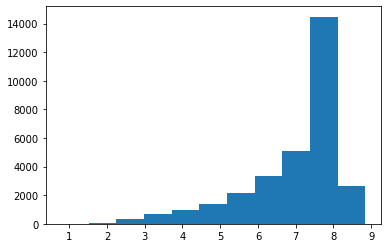

In [76]:
plt.hist(preds, bins=11)

In [78]:
np.sort(np.ravel(preds))

array([0.78070414, 1.2796674 , 1.2862179 , ..., 8.751394  , 8.799221  ,
       8.843169  ], dtype=float32)

In [65]:
preds_lol = model_tabular.predict([get_array(train_data['User_ID']), get_array(train_data['Game_ID'])])
mean_squared_error(preds_lol, train_data['Userscore'], squared=False)

(array([  457.,   788.,  1413.,  2224.,  3740.,  5936., 10387., 32627.,
        43048.,  5238.]),
 array([ 0.       ,  1.0549437,  2.1098874,  3.164831 ,  4.2197747,
         5.2747183,  6.329662 ,  7.3846054,  8.439549 ,  9.494493 ,
        10.549437 ], dtype=float32),
 <BarContainer object of 10 artists>)

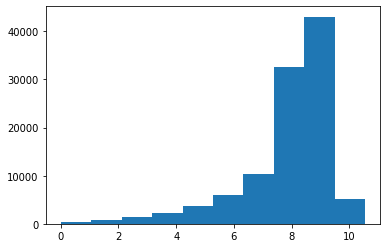

In [66]:
plt.hist(preds_lol)

In [46]:
from sklearn.model_selection import train_test_split
temp1, temp2 = train_test_split(all_data, test_size=0.1)

In [47]:
temp1

,Userscore,Username,Game_ID,User_ID
113924,5,RinShibuya,1671,11658
131315,2,WestLil0,197,14975
59978,8,CenkAlp,328,2325
54155,10,Khajiit2,99,7715
16395,8,SilentSputnik,495,12633
...,...,...,...,...
25211,7,Dragz,2823,3900
67164,6,JS96,1135,6348
23406,1,skarr,1376,20771
114762,10,synced,690,21094


In [51]:
get_array(temp1["User_ID"])

array([[11658],
       [14975],
       [ 2325],
       ...,
       [20771],
       [21094],
       [ 8374]])

In [54]:
#model_tabular.predict(get_array(temp1['User_ID']), get_array(temp2['Game_ID']), batch_size=32)
#model_tabular.predict([get_array(temp1['User_ID']), get_array(temp1['Game_ID'])])